# Introdução

Multilayer Perceptrons são redes neurais artificiais avançadas, utilizadas para uma variedade de tarefas, como classificação de imagens e processamento de sinais. Eles consistem em conjuntos de neurônios artificiais organizados em camadas, incluindo camadas de entrada, ocultas e de saída. Essas redes são progressivas, o que significa que não há retroalimentação entre os neurônios dentro de uma camada, e os sinais fluem apenas para a camada seguinte. O número de nós na camada de entrada determina o número de sinais de entrada, enquanto o número de nós na camada de saída corresponde à quantidade de sinais gerados pela rede. Essa estrutura permite que a rede produza resultados específicos para diferentes conjuntos de dados de entrada

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score


plt.style.use('default')

trainData = pd.read_csv('./input/train.csv')
testData = pd.read_csv('./input/test.csv')
result = pd.read_csv('./input/results.csv')

testData = pd.concat([testData, result["Survived"]], axis=1)

Os dados seguiam o seguinte formato:

| Variável | Definição | Valores |
|---|---|---|
| Pclass | Classe do Bilhete | 1 \| 2 \| 3 |
| Sex | Sexo | "male" \| "female" |
| Age | Idade | Anos (fracional se menor que 1)|
| Sibsp | Qtd de irmãos/conjugues a bordo |  |
| Parch | Qtd de pais/filhos a bordo |  |
| Ticket | Numero do Ticket |  |
| Fare | Taxa de passagem |  |
| Cabin | Numero da Cabine |  |
| Embarked | Porto de Embarque | C = Cherbourg, Q = Queenstown, S = Southampton |

Removemos de cara os valores que não interessavam para a previsão.

In [15]:
trainData = trainData.drop(["Cabin","Ticket","Name","Embarked", "PassengerId"], axis=1)
testData = testData.drop(["Cabin","Ticket","Name","Embarked", "PassengerId"], axis=1)

Percebemos que háviam muitas idades inválidas. É importante saber quantas e se outras colunas também estavam com dados faltando, e se for o caso, trata-los

In [16]:
print("Training DataSet:")
print(trainData.isna().sum())
print("Test DataSet:")
print(testData.isna().sum())

Training DataSet:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64
Test DataSet:
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Survived     0
dtype: int64


Usamos o `InterativeImputer` do `Scikit`, que basicamente tenta aproximar o valor que está faltando na coluna idade à partir das outras 2 colunas, iterando recursivamente até chegar em um valor que talvez seja próximo do valor real, podemos parametrizar ele mais, mas deixamos no comportamento padrão.  
> Existem outros métodos de se imputar valores como o `SimpleImputer`, ou simplesmente tentar fazer uma média, moda ou mediana para preencher os valores que estão faltando. Mas no nosso caso o InterativeImputer funcionou bem.

qtd de idades inválidas: 0


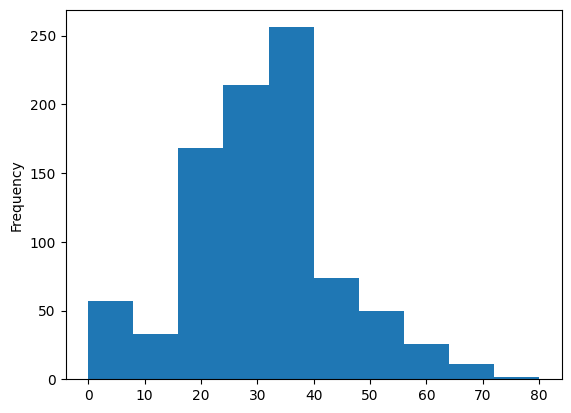

In [17]:
columns = ["SibSp", "Parch", "Age"]
imputer = IterativeImputer(min_value = 0)

imputedValues = imputer.fit_transform(trainData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
trainData["Age"] = correctedValues["Age"]

imputedValues = imputer.fit_transform(testData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
testData["Age"] = correctedValues["Age"]

trainData["Age"].plot(kind='hist')
print(f"qtd de idades inválidas: {trainData['Age'].isna().sum()}")

Para conseguir plotar o gráfico corretamnete, tem algumas colunas que precisam ser modificadas, pois não estão em valores númericos

In [18]:
#Valores faltando na taxa de embarque => média
trainData["Fare"] = trainData["Fare"].replace(np.NaN, trainData["Fare"].mean())
testData["Fare"] = testData["Fare"].replace(np.NaN, testData["Fare"].mean())

#converter em valores numéricos
trainData["Sex"] = trainData["Sex"].map({"male": 0, "female": 1})
testData["Sex"] = testData["Sex"].map({"male": 0, "female": 1})

Após limpar todos os dados podemos fazer uma matriz de correlação para descobrir quais informações são mais importantes para prever a taxa de sobrevivência, tendo com base os dados de treino.

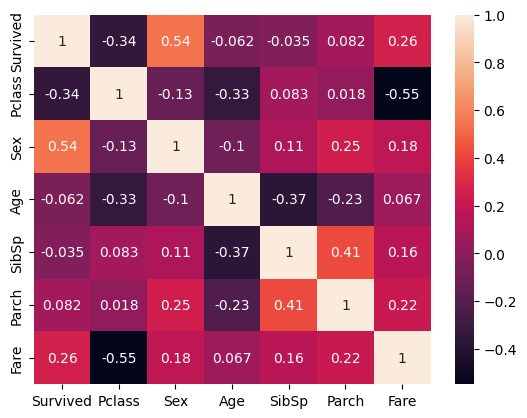

Valores não relacionados:
Age      0.061871
SibSp    0.035322
Parch    0.081629
Name: Survived, dtype: float64


In [19]:
#Vizualizar quais váriaveis são mais correlacionadas com a de sobrevivência
matrix = trainData.corr()
plt.figure()
sns.heatmap(matrix, annot=True)
plt.show()

corrSurvived = abs(matrix["Survived"])
print(f"Valores não relacionados:\n{corrSurvived[corrSurvived < 0.1]}")

Como podemos ver, a qtd de filhos e de conjugues não é um valor muito útil pra definir se a pessoa sobreviveu ou não. Então realizamos alguns tratamentos para tornar os dados mais úteis e removemos os dados brutos que podem causar ruído.

In [20]:
#Criamos essa coluna temporaria "FamilyCount" somando a qtd de filhos e de conjugues ao passageiro
#O dado mais relevante é saber se o passageiro está sozinho ou não.
trainData["FamilyCount"] = trainData['SibSp'] + trainData['Parch'] + 1
testData["FamilyCount"] = testData['SibSp'] + testData['Parch'] + 1
trainData['IsAlone'] = trainData["FamilyCount"] == 1
testData['IsAlone'] = testData["FamilyCount"] == 1

trainData = trainData.drop(["SibSp","Parch", "FamilyCount"], axis=1)
testData = testData.drop(["SibSp","Parch", "FamilyCount"], axis=1)

#removo qualquer NaN remanescente.
trainData = trainData.dropna().reset_index(drop=True)
testData = testData.dropna().reset_index(drop=True)

Verificando novamente:

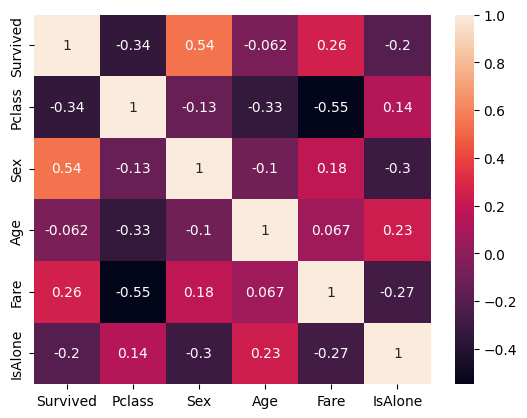

Valores não relacionados:
Age    0.061871
Name: Survived, dtype: float64


In [21]:
#Vizualizar quais váriaveis são mais correlacionadas com a de sobrevivência
matrix = trainData.corr()
plt.figure()
sns.heatmap(matrix, annot=True)
plt.show()

corrSurvived = abs(matrix["Survived"])
print(f"Valores não relacionados:\n{corrSurvived[corrSurvived < 0.1]}")

In [22]:
#idade continua pouco correlacionado à sobrevivência, então podemos remover

trainData = trainData.drop(["Age"], axis=1)
testData = testData.drop(["Age"], axis=1)

# Treinando MLP

O dataset já fornece o conjunto de dados de teste e treino, então não precisamos fazer split

In [23]:
trainX = trainData.drop(["Survived"], axis=1).values
trainY = trainData["Survived"].values

#Normalização dos dados
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)

testX = testData.drop(["Survived"], axis=1).values
testX = scaler.transform(testX)
testY = testData["Survived"].values

In [24]:
#Configuração do MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(300,),
    activation='relu',
    learning_rate_init=0.001,
    solver='adam',
    max_iter=500,
    tol=1e-4,
    batch_size='auto',
    verbose=True 
)

Iteration 1, loss = 0.64995032
Iteration 1, loss = 0.60016861
Iteration 1, loss = 0.56343826
Iteration 1, loss = 0.53379383
Iteration 1, loss = 0.51242176
Iteration 1, loss = 0.49696199
Iteration 1, loss = 0.48535172
Iteration 1, loss = 0.47641071
Iteration 1, loss = 0.46979976
Iteration 1, loss = 0.46483591
Iteration 1, loss = 0.46058599
Iteration 1, loss = 0.45737198
Iteration 1, loss = 0.45528882
Iteration 1, loss = 0.45327415
Iteration 1, loss = 0.45151505
Iteration 1, loss = 0.44996975
Iteration 1, loss = 0.44873450
Iteration 1, loss = 0.44740310
Iteration 1, loss = 0.44639851
Iteration 1, loss = 0.44541431
Iteration 1, loss = 0.44442708
Iteration 1, loss = 0.44371396
Iteration 1, loss = 0.44287931
Iteration 1, loss = 0.44232291
Iteration 1, loss = 0.44167664
Iteration 1, loss = 0.44121861
Iteration 1, loss = 0.44062362
Iteration 1, loss = 0.44000541
Iteration 1, loss = 0.43991879
Iteration 1, loss = 0.43926073
Iteration 1, loss = 0.43858630
Iteration 1, loss = 0.43819150
Iteratio

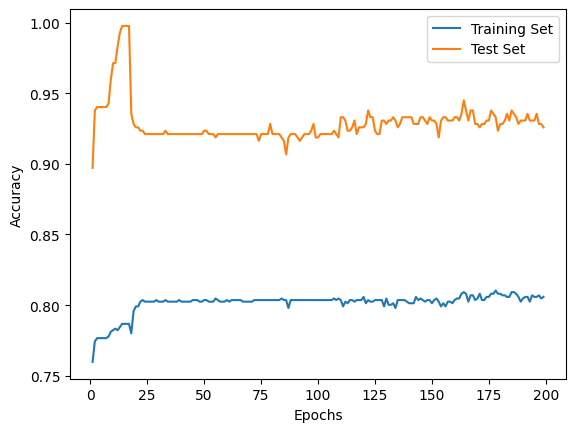

In [25]:
#Treinamento do modelo
trainScores = []
testScores = []
bestScore = 0

# Treina o modelo com vários valores de epoca
for epoch in range(1, 200):
    mlp.partial_fit(trainX, trainY, classes=np.unique(trainY))
    
    # Set de treino
    trainPred = mlp.predict(trainX)
    trainScore = accuracy_score(trainY, trainPred)
    trainScores.append(trainScore)
    
    # Set de teste
    testPred = mlp.predict(testX)
    testScore = accuracy_score(testY, testPred)
    testScores.append(testScore)
    if(testScore > bestScore): testPrediction = testPred;

# Compara através de um grafico
epochs = np.arange(1, len(trainScores) + 1)
plt.plot(epochs, trainScores, label='Training Set')
plt.plot(epochs, testScores, label='Test Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
#Matriz de confusão
cm = confusion_matrix(testY, testPrediction)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'testPrediction' is not defined